In [14]:
import pandas as pd

# Đọc dữ liệu từ file
file_path = 'TSLA Historical Data.csv'
tesla_data = pd.read_csv(file_path)

# Hiển thị thông tin ban đầu về dữ liệu
tesla_data.info()
print(tesla_data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1448 non-null   object 
 1   Price     1448 non-null   float64
 2   Open      1448 non-null   float64
 3   High      1448 non-null   float64
 4   Low       1448 non-null   float64
 5   Vol.      1448 non-null   object 
 6   Change %  1448 non-null   object 
dtypes: float64(4), object(3)
memory usage: 79.3+ KB
         Date   Price    Open    High     Low    Vol. Change %
0  10/10/2024  241.80  241.81  242.76  232.50  61.61M    0.31%
1  10/09/2024  241.05  243.82  247.43  239.51  66.29M   -1.41%
2  10/08/2024  244.50  243.56  246.21  240.56  56.30M    1.52%
3  10/07/2024  240.83  249.00  249.83  240.70  68.11M   -3.70%
4  10/04/2024  250.08  246.69  250.96  244.58  86.73M    3.91%


In [15]:
# Chuyển đổi cột 'Date' thành định dạng datetime và tách thành cột ngày, tháng, năm
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'], format='%m/%d/%Y')
tesla_data['Day'] = tesla_data['Date'].dt.day
tesla_data['Month'] = tesla_data['Date'].dt.month
tesla_data['Year'] = tesla_data['Date'].dt.year

# Xử lý cột 'Vol.' để chuyển đổi từ triệu thành số thực
tesla_data['Vol.'] = tesla_data['Vol.'].str.replace('M', '').astype(float) * 1e6

# Xử lý cột 'Change %' để loại bỏ ký hiệu '%' và chuyển sang dạng số
tesla_data['Change %'] = tesla_data['Change %'].str.replace('%', '').astype(float) / 100

# Kiểm tra dữ liệu sau khi xử lý
print(tesla_data.head())


        Date   Price    Open    High     Low        Vol.  Change %  Day  \
0 2024-10-10  241.80  241.81  242.76  232.50  61610000.0    0.0031   10   
1 2024-10-09  241.05  243.82  247.43  239.51  66290000.0   -0.0141    9   
2 2024-10-08  244.50  243.56  246.21  240.56  56300000.0    0.0152    8   
3 2024-10-07  240.83  249.00  249.83  240.70  68110000.0   -0.0370    7   
4 2024-10-04  250.08  246.69  250.96  244.58  86730000.0    0.0391    4   

   Month  Year  
0     10  2024  
1     10  2024  
2     10  2024  
3     10  2024  
4     10  2024  


In [16]:
# Tạo thêm các đặc trưng trung bình động (MA) và độ lệch chuẩn (STD) với các khoảng thời gian khác nhau
tesla_data['MA_5'] = tesla_data['Price'].rolling(window=5).mean()
tesla_data['MA_10'] = tesla_data['Price'].rolling(window=10).mean()
tesla_data['STD_5'] = tesla_data['Price'].rolling(window=5).std()
tesla_data['STD_10'] = tesla_data['Price'].rolling(window=10).std()

# Loại bỏ các dòng có giá trị NaN do tính toán MA và STD
tesla_data.dropna(inplace=True)

# Kiểm tra dữ liệu sau khi thêm đặc trưng
print(tesla_data.head())


         Date   Price    Open    High     Low        Vol.  Change %  Day  \
9  2024-09-27  260.46  257.38  260.70  254.12  70990000.0    0.0245   27   
10 2024-09-26  254.22  260.60  261.75  251.53  67140000.0   -0.0109   26   
11 2024-09-25  257.02  252.54  257.05  252.28  65030000.0    0.0108   25   
12 2024-09-24  254.27  254.08  257.19  249.05  88490000.0    0.0171   24   
13 2024-09-23  250.00  242.61  250.00  241.92  86930000.0    0.0493   23   

    Month  Year     MA_5    MA_10     STD_5    STD_10  
9       9  2024  253.958  248.805  8.928271  8.462942  
10      9  2024  256.670  250.047  5.131111  8.228804  
11      9  2024  258.270  251.644  2.920325  7.828663  
12      9  2024  257.520  252.621  3.436503  7.437932  
13      9  2024  255.194  253.538  3.867981  6.301134  


In [17]:
# Lưu lại bộ dữ liệu sau khi tiền xử lý sơ bộ
tesla_data.to_csv('data_preprocessed.csv')

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Chuẩn bị X và y từ dữ liệu
X = tesla_data.drop(columns=['Date', 'Price'])
y = tesla_data['Price']

# Khởi tạo và chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Khởi tạo số lượng folds cho K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Hàm đánh giá mô hình với K-Fold
def evaluate_model_kfold(model, X, y, kf):
    mae_list, mse_list, rmse_list, r2_list = [], [], [], []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mae_list.append(mean_absolute_error(y_test, y_pred))
        mse_list.append(mean_squared_error(y_test, y_pred))
        rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2_list.append(r2_score(y_test, y_pred))
    
    return np.mean(mae_list), np.mean(mse_list), np.mean(rmse_list), np.mean(r2_list)

# Tìm tham số tốt nhất với GridSearchCV cho Ridge
param_grid_ridge = {'alpha': [0.1, 1.0, 10.0, 100.0]}
ridge_grid_search = GridSearchCV(Ridge(), param_grid_ridge, cv=kf, scoring='neg_mean_squared_error')
ridge_grid_search.fit(X_scaled, y)
best_ridge = ridge_grid_search.best_estimator_
print("Best parameters for Ridge:", ridge_grid_search.best_params_)

# Tìm tham số tốt nhất với GridSearchCV cho MLP, với max_iter cố định là 2000
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'alpha': [0.0001, 0.001, 0.01]
}
mlp_grid_search = GridSearchCV(MLPRegressor(max_iter=4000, random_state=42), param_grid_mlp, cv=kf, scoring='neg_mean_squared_error')
mlp_grid_search.fit(X_scaled, y)
best_mlp = mlp_grid_search.best_estimator_
print("Best parameters for MLP:", mlp_grid_search.best_params_)

# Linear Regression không cần tối ưu hóa, sử dụng mặc định
lr_model = LinearRegression()

# Đánh giá các mô hình với tham số tối ưu từ GridSearchCV
lr_eval = evaluate_model_kfold(lr_model, X_scaled, y.values, kf)
ridge_eval = evaluate_model_kfold(best_ridge, X_scaled, y.values, kf)
mlp_eval = evaluate_model_kfold(best_mlp, X_scaled, y.values, kf)

# In kết quả đánh giá
print("Linear Regression (K-Fold):", lr_eval)
print("Ridge Regression (K-Fold) với tham số tối ưu:", ridge_eval)
print("MLP Regressor (K-Fold) với tham số tối ưu:", mlp_eval)

# Xây dựng và đánh giá mô hình Stacking với các mô hình tối ưu
estimators = [
    ('linear', lr_model),
    ('ridge', best_ridge),
    ('mlp', best_mlp)
]
stacking_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking_eval = evaluate_model_kfold(stacking_model, X_scaled, y.values, kf)
print("Stacking Model (K-Fold) với các mô hình tối ưu:", stacking_eval)

# Lưu scaler và các mô hình đã huấn luyện
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(lr_model, 'linear_regression_model.pkl')
joblib.dump(best_ridge, 'ridge_regression_model.pkl')
joblib.dump(best_mlp, 'mlp_model.pkl')
joblib.dump(stacking_model, 'stacking_model.pkl')


Best parameters for Ridge: {'alpha': 0.1}
Best parameters for MLP: {'alpha': 0.01, 'hidden_layer_sizes': (100,)}
Linear Regression (K-Fold): (np.float64(1.6480002254102957), np.float64(5.666137080063454), np.float64(2.3779119703948335), np.float64(0.9994480805506647))
Ridge Regression (K-Fold) với tham số tối ưu: (np.float64(1.6795105764066265), np.float64(5.762420948294335), np.float64(2.398050140225429), np.float64(0.999438878109283))
MLP Regressor (K-Fold) với tham số tối ưu: (np.float64(1.829550389716329), np.float64(7.149704709767289), np.float64(2.6693135584168526), np.float64(0.9993041394390992))
Stacking Model (K-Fold) với các mô hình tối ưu: (np.float64(1.6509335594758707), np.float64(5.707157898089613), np.float64(2.386510224024751), np.float64(0.9994439612752851))


['stacking_model.pkl']

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Định nghĩa hàm đánh giá các chỉ số MAE, MSE, RMSE và R^2
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)  # Tính MSE
    rmse = np.sqrt(mse)  # Tính RMSE từ MSE bằng cách lấy căn bậc hai
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# Huấn luyện lại các mô hình trên toàn bộ tập dữ liệu huấn luyện để có dự đoán cuối cùng
lr_model.fit(X_scaled, y)
best_ridge.fit(X_scaled, y)
best_mlp.fit(X_scaled, y)
stacking_model.fit(X_scaled, y)

# Dự đoán trên toàn bộ tập dữ liệu
lr_pred = lr_model.predict(X_scaled)
ridge_pred = best_ridge.predict(X_scaled)
mlp_pred = best_mlp.predict(X_scaled)
stacking_pred = stacking_model.predict(X_scaled)

# Đánh giá các mô hình
lr_eval = evaluate_model(y, lr_pred)
ridge_eval = evaluate_model(y, ridge_pred)
mlp_eval = evaluate_model(y, mlp_pred)
stacking_eval = evaluate_model(y, stacking_pred)

# Tạo DataFrame để hiển thị kết quả
evaluation_results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'MLP Regressor', 'Stacking Model'],
    'MAE': [lr_eval[0], ridge_eval[0], mlp_eval[0], stacking_eval[0]],
    'MSE': [lr_eval[1], ridge_eval[1], mlp_eval[1], stacking_eval[1]],
    'RMSE': [lr_eval[2], ridge_eval[2], mlp_eval[2], stacking_eval[2]],
    'R^2': [lr_eval[3], ridge_eval[3], mlp_eval[3], stacking_eval[3]]
})

# Hiển thị kết quả đánh giá
print(evaluation_results)


               Model       MAE       MSE      RMSE       R^2
0  Linear Regression  1.630440  5.516888  2.348806  0.999467
1   Ridge Regression  1.655224  5.578697  2.361927  0.999461
2      MLP Regressor  1.490751  4.576526  2.139282  0.999557
3     Stacking Model  1.633971  5.546844  2.355174  0.999464


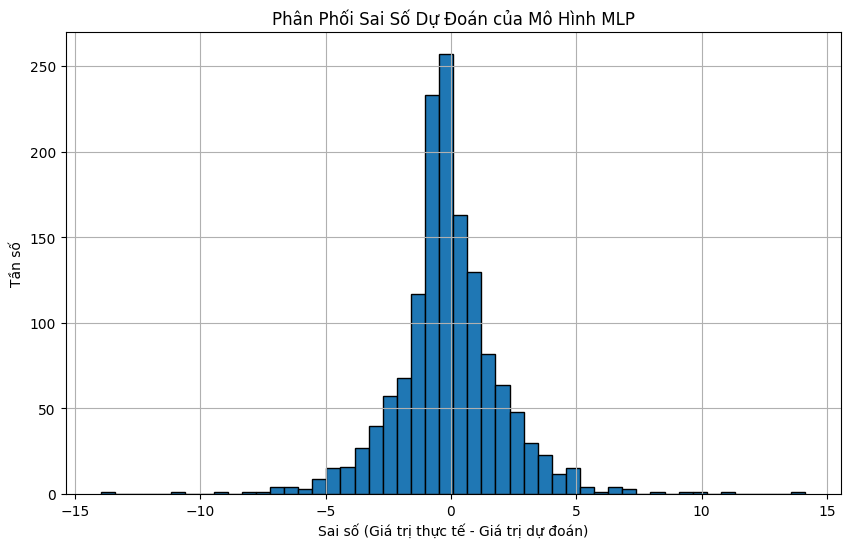

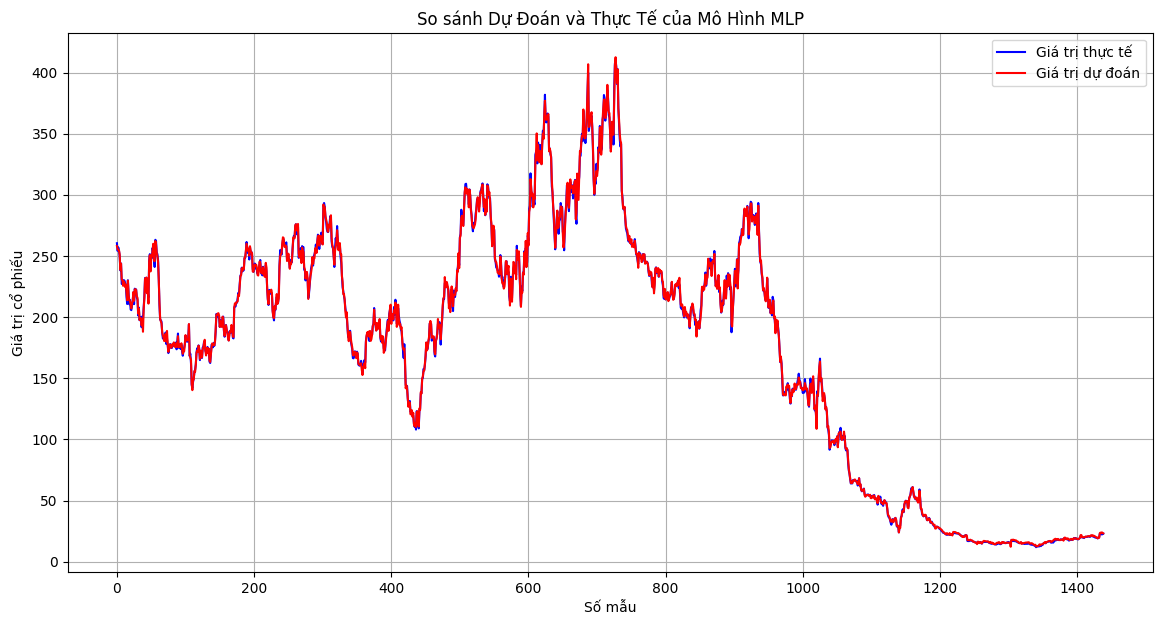

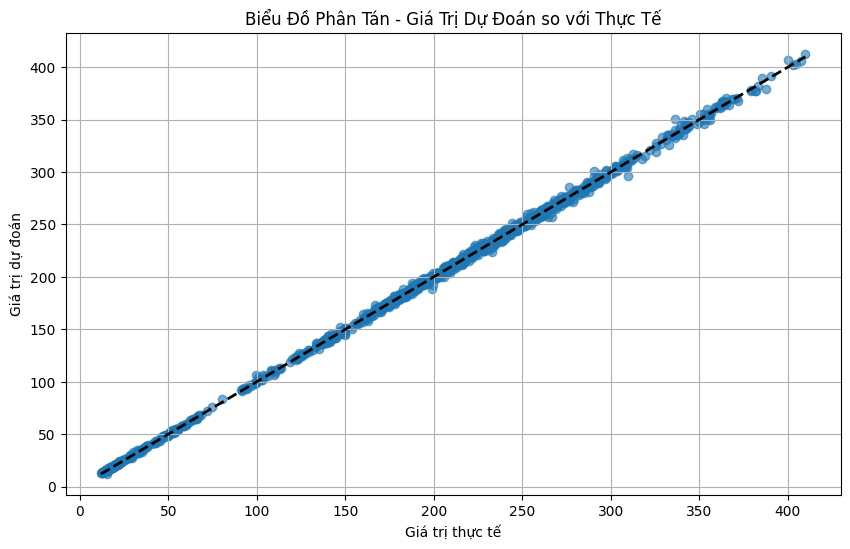

In [20]:
import matplotlib.pyplot as plt

# Sử dụng MLP làm mô hình tốt nhất
best_model = best_mlp

# Dự đoán trên toàn bộ tập dữ liệu
y_pred_best = best_model.predict(X_scaled)

### Bước 1: Phân Tích Lỗi
# Tính toán sai số dự đoán
errors = y - y_pred_best

# Trực quan hóa phân phối sai số dự đoán với biểu đồ histogram
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, edgecolor='k')
plt.title('Phân Phối Sai Số Dự Đoán của Mô Hình MLP')
plt.xlabel('Sai số (Giá trị thực tế - Giá trị dự đoán)')
plt.ylabel('Tần số')
plt.grid(True)
plt.show()

### Bước 2: Trực Quan Hóa Kết Quả Dự Đoán so với Thực Tế

# 1. Biểu đồ đường: So sánh giá trị dự đoán và giá trị thực tế
plt.figure(figsize=(14, 7))
plt.plot(y.values, label='Giá trị thực tế', color='b')
plt.plot(y_pred_best, label='Giá trị dự đoán', color='r')
plt.title('So sánh Dự Đoán và Thực Tế của Mô Hình MLP')
plt.xlabel('Số mẫu')
plt.ylabel('Giá trị cổ phiếu')
plt.legend()
plt.grid(True)
plt.show()

# 2. Biểu đồ phân tán: Dự đoán so với giá trị thực tế
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_best, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.title('Biểu Đồ Phân Tán - Giá Trị Dự Đoán so với Thực Tế')
plt.xlabel('Giá trị thực tế')
plt.ylabel('Giá trị dự đoán')
plt.grid(True)
plt.show()


In [9]:
# Lưu scaler và tất cả các mô hình đã huấn luyện
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(lr_model, 'linear_regression_model.pkl')
joblib.dump(best_ridge, 'ridge_regression_model.pkl')
joblib.dump(best_mlp, 'mlp_model.pkl')
joblib.dump(stacking_model, 'stacking_model.pkl')

print("Scaler và 4 mô hình đã được lưu thành công.")


Scaler và 4 mô hình đã được lưu thành công.


In [21]:
# Lưu danh sách các tên cột để sử dụng khi dự đoán
column_order = X.columns.tolist()
joblib.dump(column_order, 'columns.pkl')

['columns.pkl']

In [22]:
X.columns

Index(['Open', 'High', 'Low', 'Vol.', 'Change %', 'Day', 'Month', 'Year',
       'MA_5', 'MA_10', 'STD_5', 'STD_10'],
      dtype='object')